## Uncertainty estimate in ragmac_xdem - Part 2

This notebook describes how uncertainty in glacier outlines and gap-filling are handled in ragmac_xdem.

### Load modules

In [1]:
import os
from ragmac_xdem import files, utils
from ragmac_xdem import dem_postprocessing as pproc
from ragmac_xdem import main
from ragmac_xdem import mass_balance as mb
from ragmac_xdem import uncertainty as err

import matplotlib.pyplot as plt
import numpy as np
import xdem

# can be set to 'notebook' to use interactive plots, but will take longer to display
%matplotlib inline  
plt.rcParams["image.interpolation"] = "none"
plt.rcParams['figure.dpi'] = 120

# 0 - First Load input data

Works only after `scripts/main_experiment2.py -c PK_Baltoro -mode DEMdiff_median -run CTL` has been run successfully.

### Get path to results diretory

In [2]:
case = "PK_Baltoro"
run_name = "CTL"
mode = "DEMdiff_median"
run = main.runs[run_name]
exp = files.get_data_paths(case)
process_dir = exp["processed_data"]["directory"]
# coreg_dir = os.path.join(process_dir, run["coreg_dir"])
outdir = os.path.join(process_dir, f"results_{run_name}_{mode}")
print(outdir)

/Users/adehecq/work/RAGMAC/ragmac_xdem/data/processed/experiment_2/PK_Baltoro/results_CTL_DEMdiff_median


### Load ddems

In [3]:
ref_dem, all_outlines, roi_outlines, roi_mask, stable_mask = utils.load_ref_and_masks(exp)
validation_dates = exp["validation_dates"]
ddems = pproc.merge_and_calculate_ddems([], validation_dates, ref_dem, outdir=outdir, 
                                        overwrite=False, mode="median")
print(list(ddems.keys()))

Loading existing files
['2000_2012', '2000_2019', '2012_2019']


### Take the '2000-2019' dh map as an example

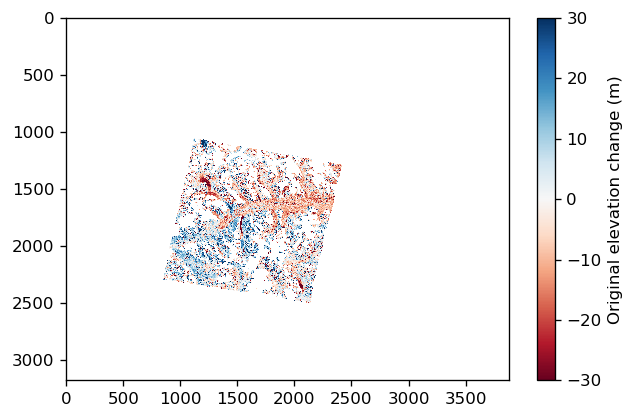

In [4]:
dh = ddems["2000_2019"]
plt.imshow(dh.data.squeeze(), cmap="RdBu", vmin=-30, vmax=30)
cb = plt.colorbar()
cb.set_label("Original elevation change (m)")

### Fill gaps

In [5]:
ddem_filled, ddem_bins, ddem_bins_filled, interp_residuals = mb.fill_ddem_local_hypso(
                dh,
                ref_dem,
                roi_mask,
                roi_outlines,
                filtering=run["filtering"]
            )

Remove 29 outliers by count threshold
Remove 0 outliers by NMAD filter


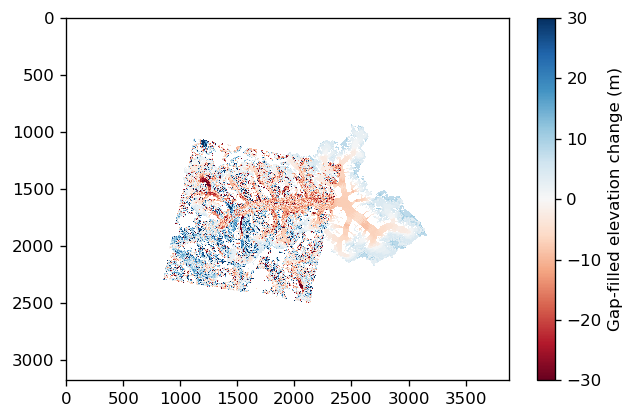

In [6]:
plt.imshow(ddem_filled.data.squeeze(), cmap="RdBu", vmin=-30, vmax=30)
cb = plt.colorbar()
cb.set_label("Gap-filled elevation change (m)")

# 1- Uncertainties related to glacier outlines

For area uncertainties, we assume a 30 m error in the outlines. Hence, we apply a 30 m buffer to the existing outlines, and calculate for each glacier/polygon the relative change in area.

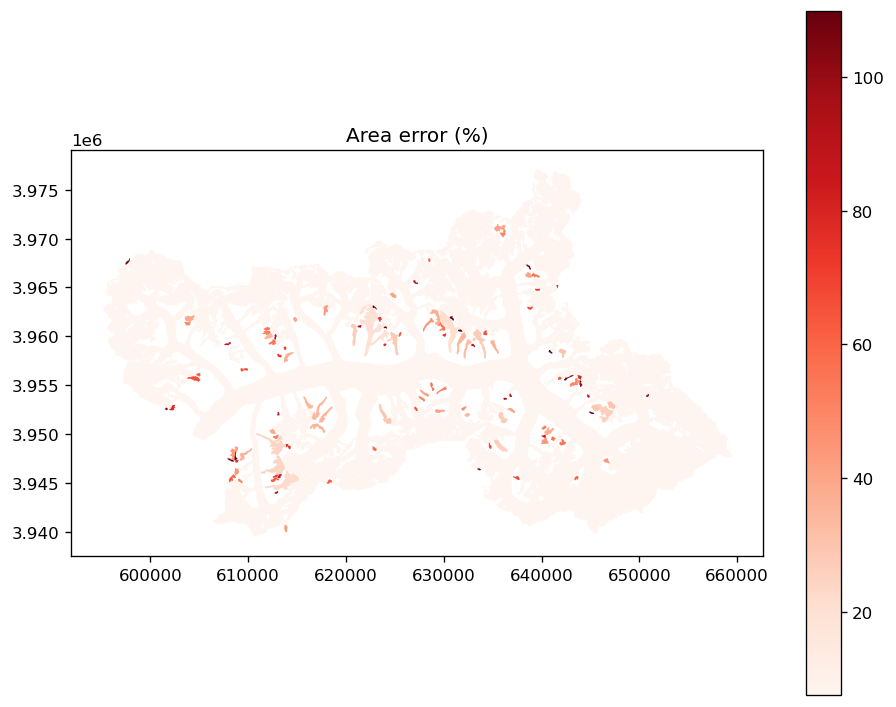

In [7]:
area_err = err.err_area_buffer(roi_outlines, buffer=30, plot=True)

**The estimated area error is ~10% for the largest Baltoro glacier, which is close to the litterature standard. But much larger for the small glaciers, for which a small outline error translate into a large area change.**

# 2 - Uncertainties related to gap-filling

We compare interpolation residuals relative to elevation change.

In [8]:
interp_err_rel = interp_residuals / dh

<IPython.core.display.Javascript object>


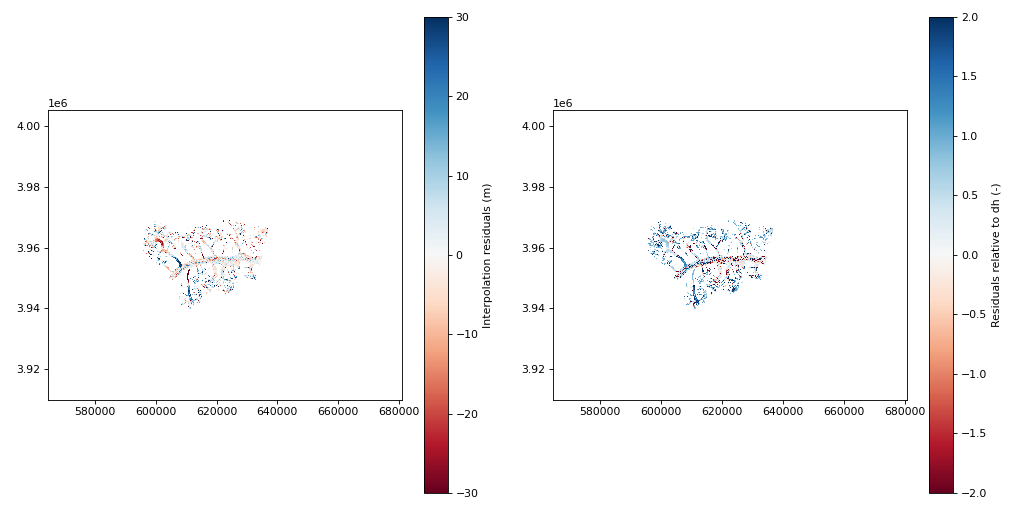

In [9]:
%matplotlib notebook
plt.figure(figsize=(12,6))
ax1 = plt.subplot(121)
interp_residuals.show(ax=ax1, cmap="RdBu", vmin=-30, vmax=30, cb_title="Interpolation residuals (m)")
ax2 = plt.subplot(122)
interp_err_rel.show(ax=ax2, cmap="RdBu", vmin=-2, vmax=2, cb_title="Residuals relative to dh (-)")
plt.tight_layout()

We observe that:
* the residuals are larger over glaciers that deviate from the norm, e.g., surging glaciers
* the residuals are up to 1-2 times the actual elevation change. 
Let's estimate the distribution's 1 and 2 sigma.

In [10]:
p68, p95 = np.percentile(np.abs(interp_err_rel.data.compressed()), [68, 95])
print(p68, p95)

1.077809424988769 5.3024415378564465


At 2-sigma, should we assume that gaps have 5 times the dh uncertainty? This is similar to the "magic factor" of five used e.g. in Brun et al. (2017).